# Installation and dependencies

In [1]:
%pip install tensorflow==2.14.1 opencv-python matplotlib

Note: you may need to restart the kernel to use updated packages.


In [2]:
# Standard dependencies
import cv2
import os
import random
import numpy as np
import matplotlib.pyplot as plt
from zipfile import ZipFile
import shutil
import time

In [3]:
# Tensorflow dependencies
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Conv2D, Dense, MaxPooling2D, Input, Flatten
import tensorflow as tf

# Creating data directories

In [4]:
# Setting up dirs
POS_DIR = os.path.join("data", "positive")
NEG_DIR = os.path.join("data", "negative")
ANC_DIR = os.path.join("data", "anchor")

# Checking if the folders exist
POS_DIR_isExist = os.path.exists(POS_DIR)
NEG_DIR_isExist = os.path.exists(NEG_DIR)
ANC_DIR_isExist = os.path.exists(POS_DIR)

# Creating dirs
os.makedirs(POS_DIR) if not POS_DIR_isExist else None
os.makedirs(NEG_DIR) if not NEG_DIR_isExist else None
os.makedirs(ANC_DIR) if not ANC_DIR_isExist else None

# Data collection

## Collecting positive examples

In [5]:
'''
    Dataset:
    https://www.kaggle.com/datasets/jessicali9530/lfw-dataset?resource=download
'''

# Unzipping kaggle data
with ZipFile("archive.zip", "r") as zip_object:
    zip_object.extractall()

# Replace old paths with new paths
lfw = "lfw-deepfunneled/lfw-deepfunneled/"

# Move the images to negative example
for dir in os.listdir(lfw):
    for file in os.listdir(os.path.join(lfw, dir)):
        OLD_PATH = os.path.join(lfw, dir, file)
        NEW_PATH = os.path.join(NEG_DIR, file)
        os.replace(OLD_PATH, NEW_PATH)

# Remove now empty directory
shutil.rmtree("lfw-deepfunneled")

# Set up webcam for postive and anchor collection

In [6]:
# Function for cutting the frame to match image data
def center_crop(img, dim):
    width, height  = img.shape[1], img.shape[0]

    crop_width = dim[0] if dim[0]<img.shape[1] else img.shape[1]
    crop_height = dim[1] if dim[1]<img.shape[0] else img.shape[0]

    mid_x, mid_y = int(width/2), int(height/2)
    cw2, ch2 = int(crop_width/2), int(crop_height/2) 

    crop_img = img[mid_y-ch2:mid_y+ch2, mid_x-cw2:mid_x+cw2, :]

    return crop_img

In [7]:
# Import uuid library
import uuid
# uuid.uuid1()

In [8]:
# Constructing camera object
deviceID = 0 # 0-webcam, 1-laptop
cap = cv2.VideoCapture(deviceID)

# Error handling when opening the camera is not available
if not cap.isOpened():
    exit()

while cap.isOpened():
    # Capture return value and frame
    ret, frame = cap.read()

    # Error handling if no return value
    if not ret:
        break

    # Reduced the frame
    size = (250, 250)
    frame = center_crop(frame, size)

    # Collect anchors
    if cv2.waitKey(1) & 0xFF == ord("a"):
        imgname = os.path.join(ANC_DIR, "{}.jpg".format(uuid.uuid1()))
        cv2.imwrite(imgname, frame)

    # Collect positives
    if cv2.waitKey(1) & 0xFF == ord("p"):
        imgname = os.path.join(POS_DIR, "{}.jpg".format(uuid.uuid1()))
        cv2.imwrite(imgname, frame)

    # Show the frame
    cv2.imshow("Webcam frame", frame)
    # Creating quit key
    if cv2.waitKey(1) & 0xFF == ord("q"):
        break

# Release the capture and destroy frames
cap.release()
cv2.destroyAllWindows()
cv2.waitKey(1)

-1

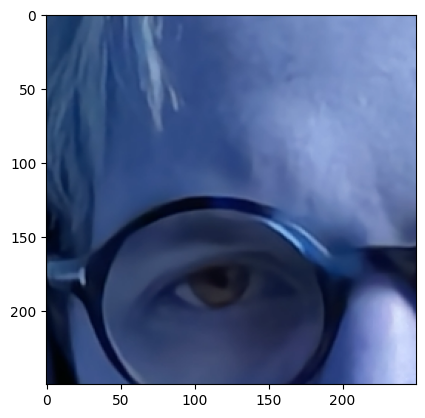

In [9]:
plt.imshow(frame)

# Dataloader and preprocessing

In [10]:
anchor = tf.data.Dataset.list_files(ANC_DIR + "/*.jpg").take(300)
positive = tf.data.Dataset.list_files(POS_DIR + "/*.jpg").take(300)
negative = tf.data.Dataset.list_files(NEG_DIR + "/*.jpg").take(300)

In [11]:
dir_test = anchor.as_numpy_iterator()

In [12]:
print(dir_test.next())

b'data/anchor/7f5b4bf4-c106-11ee-949d-9a60f45df4af.jpg'


In [13]:
# Image preprocessing
def preprocess(path):
    # Read in image
    byte_img = tf.io.read_file(path)
    # Decode jpeg
    img = tf.io.decode_jpeg(byte_img)
    # Resizing image 
    img = tf.image.resize(img, (105, 105))
    # Normalising values
    img = img / 255.0
    # Return image
    return img

In [14]:
img = preprocess('data/anchor/49da636e-c108-11ee-bd9f-9a60f45df4af.jpg')

In [15]:
print(f"MIN: {img.numpy().min()}, MAX: {img.numpy().max()}")

MIN: 0.0, MAX: 0.6457515954971313


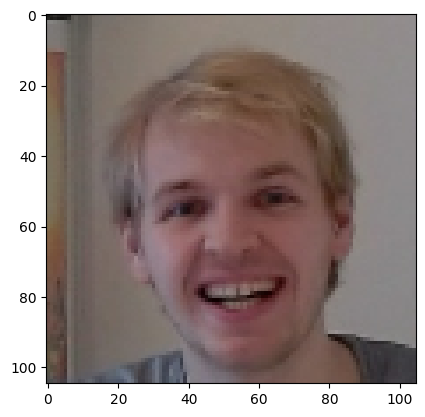

In [16]:
plt.imshow(img)

In [17]:
positives = tf.data.Dataset.zip((anchor, positive, tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))
negatives = tf.data.Dataset.zip((anchor, negative, tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))))
data = positives.concatenate(negatives)

In [18]:
test_sample = data.as_numpy_iterator()

In [19]:
example = test_sample.next()
example

(b'data/anchor/2f69e1ee-c108-11ee-bd9f-9a60f45df4af.jpg',
 b'data/positive/183f1916-c109-11ee-bd9f-9a60f45df4af.jpg',
 1.0)

## Preprocess the data

In [20]:
def preprocess_twin(input_image, validation_image, label):
    return(preprocess(input_image), preprocess(validation_image), label)

In [21]:
res = preprocess_twin(*example)

In [22]:
# Dataloader pipeline
data = data.map(preprocess_twin)
data = data.cache()
data = data.shuffle(buffer_size=1024)

## Train test partitioning

In [23]:
# Training partitioning
train_data = data.take(round(len(data)*.7)) # 70% training data
train_data = train_data.batch(16)           # Ensuring same sample size
train_data = train_data.prefetch(8)         # Prepares next preprocessing

In [24]:
# Test partioning
test_data = data.skip(round(len(data)*.7))  # Skipping the train data
test_data = data.take(round(len(data)*.3))  # Retrieving test data (30%)
test_data = test_data.batch(16)
test_data = test_data.prefetch(8)

# Building neural network

## Embedding layer

In [25]:
inp = Input(shape=(105, 105, 3), name="input_image")
c1 = Conv2D(64, (10, 10), activation="relu")(inp)
max1 = MaxPooling2D(pool_size=(2, 2), padding="valid")(c1)
c2 = Conv2D(128, (7, 7), activation="relu")(max1)
m2 = MaxPooling2D(pool_size=(2, 2), padding="same")(c2)
 # Block 3
c3 = Conv2D(128, (4, 4), activation="relu")(m2)
m3 = MaxPooling2D(pool_size=(2, 2), padding="same")(c3)

    # Block 4 (Final layer)
c4 = Conv2D(256, (4, 4), activation="relu")(m3)
f1 = Flatten()(c4)
d1 = Dense(4096, activation="sigmoid")(f1)

In [26]:
mod = Model(inputs=inp, outputs=d1, name="embedding")
mod.summary()

Model: "embedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_image (InputLayer)    [(None, 105, 105, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 96, 96, 64)        19264     
                                                                 
 max_pooling2d (MaxPooling2  (None, 48, 48, 64)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 42, 42, 128)       401536    
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 21, 21, 128)       0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 18, 18, 128)       26

In [27]:
def make_embedding():
    # Input layer
    inp = Input(shape=(105, 105, 3), name="input_image")
    # Block 1
    c1 = Conv2D(64, (10, 10), activation="relu")(inp)
    m1 = MaxPooling2D(pool_size=(2, 2), padding="same")(c1)

    # Block 2
    c2 = Conv2D(128, (7, 7), activation="relu")(m1)
    m2 = MaxPooling2D(pool_size=(2, 2), padding="same")(c2)

    # Block 3
    c3 = Conv2D(128, (4, 4), activation="relu")(m2)
    m3 = MaxPooling2D(pool_size=(2, 2), padding="same")(c3)

    # Block 4 (Final layer)
    c4 = Conv2D(256, (4, 4), activation="relu")(m3)
    f1 = Flatten()(c4)
    d1 = Dense(4096, activation="sigmoid")(f1)


    return Model(inputs=inp, outputs=d1, name="embedding")

In [33]:
embedding = make_embedding()

In [34]:
embedding.summary()

Model: "embedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_image (InputLayer)    [(None, 105, 105, 3)]     0         
                                                                 
 conv2d_8 (Conv2D)           (None, 96, 96, 64)        19264     
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 48, 48, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_9 (Conv2D)           (None, 42, 42, 128)       401536    
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 21, 21, 128)       0         
 g2D)                                                            
                                                                 
 conv2d_10 (Conv2D)          (None, 18, 18, 128)       26

## Distance layer

In [30]:
# Siamese distance layer
class L1Dist(Layer):
    # Class init
    def __init__(self, **kwargs):
        super().__init__()
    
    # Distance calculation (Similarity)
    def call(self, input_embedding, validation_embedding):
        return tf.math.abs(input_embedding - validation_embedding)
    

In [31]:
l1 = L1Dist()

In [ ]:
l1(anchor_embedding, validation_embedding)

## Combining the Siamese Network

In [39]:
def make_siamese_network():
    # Input
    input_image = Input(name="input_image", shape=(105, 105, 3))                # Anchor
    validation_image = Input(name="validation_image", shape=(105, 105, 3))      # Validation

    # Combine with siamese distance
    siamese_distance = L1Dist()
    siamese_distance._name = "distance"
    distances = siamese_distance(embedding(input_image), embedding(validation_image))

    # Final classification
    classifier = Dense(1, activation="sigmoid")(distances)

    # return the model
    return Model(inputs=[input_image, validation_image], outputs=classifier, name="SiameseNetwork")
    

In [40]:
siamese_model = make_siamese_network()
siamese_model.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_image (InputLayer)    [(None, 105, 105, 3)]        0         []                            
                                                                                                  
 validation_image (InputLay  [(None, 105, 105, 3)]        0         []                            
 er)                                                                                              
                                                                                                  
 embedding (Functional)      (None, 4096)                 3896044   ['input_image[0][0]',         
                                                          8          'validation_image[0][0]']    
                                                                                     